# Mean firing rate across session pooled across all animals

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from neuropy.plotting import Fig
from scipy.ndimage import gaussian_filter1d
import subjects

sd_sessions = subjects.sd.allsess[2:-1]
nsd_sessions = subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2
print(sd_sessions)

In [ ]:
sd_df = pd.DataFrame()
nsd_df = pd.DataFrame()
for grp_ind, sessions in enumerate([sd_sessions,nsd_sessions]):
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"]
        maze = sess.paradigm["maze"]
        post = sess.paradigm["post"]
        rec_duration = sess.eegfile.duration
        neurons = sess.neurons.get_neuron_type("mua")

        bin_size = 60
        bin_spk_pre = neurons.time_slice(pre[0], maze[1]).get_binned_spiketrains(
            bin_size=bin_size
        )
        bin_spk_post = neurons.time_slice(maze[1], maze[1]+9*3600).get_binned_spiketrains(
            bin_size=bin_size
        )

        bins = np.arange(-bin_spk_pre.n_bins,bin_spk_post.n_bins)
        spkcounts = np.hstack((bin_spk_pre.spike_counts,bin_spk_post.spike_counts))
        spkcounts = gaussian_filter1d(spkcounts,sigma=2,axis=-1)
        frate = spkcounts/bin_size
        frate_zscore = stats.zscore(frate, axis=1)
        mean_frate = np.mean(frate_zscore, axis=0)
        # mean_frate = gaussian_filter1d(mean_frate,sigma=2)

        if grp_ind ==0:
            sd_df = sd_df.append(
                pd.DataFrame({"bins":bins, "frate": mean_frate, "sub": sub}),
                ignore_index=True,
            )

        if grp_ind ==1:
            nsd_df = nsd_df.append(
                pd.DataFrame({"bins":bins, "frate": mean_frate, "sub": sub}),
                ignore_index=True,
            )




In [ ]:
%matplotlib widget
figure = Fig()
fig,gs = figure.draw(grid=(3,1))

for i,df in enumerate([sd_df,nsd_df]):
    mean_frate = df.groupby('bins').mean()
    x = mean_frate.index
    y = mean_frate.frate.values
    err = df.groupby('bins').sem(ddof=0).frate.values


    ax = plt.subplot(gs[i])
    # ax.errorbar(mean_frate.index,mean_frate.frate,sem_frate.frate)
    ax.fill_between(x,y-err,y+err,color='#c4c1ba')
    ax.plot(x,y,'k',lw=1)
    ax.axvline(0,ls='--')
    ax.axvline(-60,ls='--',color='r')
    ax.axvline(300,ls='--',color='k')
    ax.set_xlabel('Time bins from end of MAZE (bin size = 60 s)')
    # sns.lineplot(data=df,x='bins',y='frate',ci=68,ax=ax,palette='k')
    ax.set_ylabel('Normalized firing rate')


# Firing rate changes in pyramidal/interneuron during SD
- also compare it to no sleep deprivation
- should account for unstable cells, these maybe causing increased firing rate toward ZT5 in NSD sessions 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from neuropy.plotting import Fig
import subjects

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]

In [ ]:
for sess_ind, sessions in enumerate([sessions_sd,sessions_nsd]):
    data = pd.DataFrame()
    for sub, sess in enumerate(sessions):
        # print(sub)
        pre = sess.paradigm['pre']
        post = sess.paradigm['post']
        neurons = sess.neurons.get_neuron_type('pyr')
        spktrns = neurons.spiketrains
        sd_bins = np.arange(6)*3600 + post[0]
        frate = np.asarray([np.histogram(spk,bins=sd_bins)[0] for spk in spktrns ])/3600
        # frate= np.log10(frate)
        mean_frate = np.mean(frate,axis=0)
        data = data.append(pd.DataFrame({'frate':frate.flatten(),'bins':list(np.arange(1,6))*frate.shape[0]}))




In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,2),size=(6,4),wspace=0.4)
for sess_ind, sessions in enumerate([sessions_sd,sessions_nsd]):
    data = pd.DataFrame()
    for sub, sess in enumerate(sessions):
        # print(sub)
        pre = sess.paradigm['pre']
        post = sess.paradigm['post']
        neurons = sess.neurons.get_neuron_type('pyr')
        spktrns = neurons.spiketrains
        sd_bins = np.arange(6)*3600 + post[0]
        frate = np.asarray([np.histogram(spk,bins=sd_bins)[0] for spk in spktrns ])/3600
        # frate= np.log10(frate)
        mean_frate = np.mean(frate,axis=0)
        data = data.append(pd.DataFrame({'frate':frate.flatten(),'bins':list(np.arange(1,6))*frate.shape[0]}))

    ax = plt.subplot(gs[sess_ind])
    sns.boxplot(data=data,x='bins',y='frate',color='#ccc7c7',ax=ax)
    # sns.swarmplot(data=data,x='bins',y='frate',color='k',ax=ax)
    ax.set_xlabel('ZT time')
    ax.set_title(f"{'SD' if sess_ind==0 else 'NSD'}")
    ax.set_yscale('log')

fig.suptitle('Firing rate changes first five hours of POST')

# Firing rate changes across session in SD and compare with NSD

Kamran's comment as observed from Miyawaki and Diba 2016 (Fig 1C)
> The animal is put on the track at 6am, and firing rates shoot up. In POST (next day’s light cycle) they start to come down. What happens to these firing rates in SD? In SD before Track, are they also high, or does it require TRack running?  And in NSD after track, do they come down, compared to SD after track?

The analysis below is for assesing that

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from neuropy.plotting import Fig
import subjects


In [ ]:
%matplotlib widget
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(4,4))
sessions = subjects.Sd().allsess + subjects.Nsd().allsess
data = pd.DataFrame()
for sub, sess in enumerate(sessions):

    tag = sess.recinfo.animal.tag
    try:
        maze = sess.epochs.maze
    except:
        maze = sess.epochs.maze1

    pre = sess.epochs.pre
    post = sess.epochs.post
    cells = sess.spikes.pyr

    pre_bins,pre_binsz = np.linspace(pre[0],pre[1],2,retstep=True)
    frate_pre = np.asarray([np.histogram(cell,bins=pre_bins)[0] for cell in cells])/pre_binsz

    maze_bins,maze_binsz = np.linspace(maze[0],maze[1],2,retstep=True)
    frate_maze = np.asarray([np.histogram(cell,bins=maze_bins)[0] for cell in cells])/maze_binsz

    sd_bins,sd_binsz = np.linspace(post[0],post[0]+5*3600,2,retstep=True)
    frate_sd = np.asarray([np.histogram(cell,bins=sd_bins)[0] for cell in cells])/sd_binsz


    post_bins,post_binsz = np.linspace(post[0]+5*3600,post[1],2,retstep=True)
    frate_post = np.asarray([np.histogram(cell,bins=post_bins)[0] for cell in cells])/post_binsz

    frate = np.hstack((frate_pre,frate_maze,frate_sd,frate_post))

    # frate= np.log10(frate)
    # mean_frate = np.mean(frate,axis=0)
    data = data.append(pd.DataFrame({'frate':frate.flatten(),'bins':list(np.arange(1,frate.shape[1]+1))*frate.shape[0]}))

data_mean = data.groupby('bins').mean()
data_sem = data.groupby('bins').sem(ddof=0)

ax = plt.subplot(gs[0])
# sns.lineplot(data=data,x='bins',y='frate',color='#ccc7c7',ax=ax,err_style='bars',ci=68)
ax.errorbar(data_mean.index.values,data_mean['frate'],yerr=data_sem['frate'],capsize=3,lw=2,color='k')
ax.axvspan(1,7,0,0.05,color='#968d8d')
ax.axvspan(7,16,0,0.05,color='#fadf80')
# ax.axvspan(7,16,0,0.05,color='#de5454')
# ax.axvspan(10,16,0,0.05,color='#de5454')
# sns.swarmplot(data=data,x='bins',y='frate',color='k',ax=ax)
ax.set_xlabel('ZT (SD period)')
ax.set_title('Firing rating changes across entire session')
ax.set_ylim([0.2,1])


In [ ]:
sess = subjects.Of().ratNday4[0]
sess.tracks.plot(["maze"])


# Pbe rate change across sleep deprivation

In [ ]:
import numpy as np
import subjects
from neuropy.utils import mathutil
from scipy.ndimage import gaussian_filter1d

sessions = subjects.sd.ratNday1+subjects.sd.ratSday3 + subjects.sd.ratUday4
# sessions = subjects.nsd.ratNday2+subjects.nsd.ratSday2

In [ ]:
%matplotlib widget
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame()
for sub, sess in enumerate(sessions):

    # sd = sess.paradigm['sd']
    post = sess.paradigm['post']
    sd = [post[0],post[0]+9*3600]
    pbe_sd = sess.pbe.time_slice(sd[0],sd[1])
    bin_size= 300
    sd_bin = np.arange(sd[0],sd[1]+bin_size,bin_size)
    hist_pbe = np.histogram(pbe_sd.starts,bins=sd_bin)[0]
    pbe_rate = hist_pbe/bin_size
    norm_pbe_rate = mathutil.min_max_scaler(pbe_rate)
    norm_pbe_rate = gaussian_filter1d(norm_pbe_rate,sigma=2)

    df = df.append(pd.DataFrame({'n_pbe':norm_pbe_rate,'tbin':(sd_bin[:-1]-sd_bin[0])/3600,'sub':sub}))


pbe_mean = df.groupby('tbin').mean().n_pbe
pbe_sem= df.groupby('tbin').sem(ddof=0).n_pbe

fig,ax = plt.subplots()
# sns.lineplot(data=df,x='tbin',y='n_pbe')
ax.fill_between(pbe_mean.index,pbe_mean-pbe_sem,pbe_mean+pbe_sem,alpha=0.5)
ax.plot(pbe_mean.index,pbe_mean)
ax.set_xlabel('Zt time')
ax.set_ylabel('PBE rate (Hz)')

# Firing rate change at NREM-REM transition during recovery sleep vs regular sleep
There can be two ways to look at the changes in firing rate
- mua firing rate (but it does not make sense, as high firing rate neurons can blur the changes)
- normalize/zscore each neurons firing rate during transition and then calculate the mean across neurons 
    - firing rate increase towards the end of NREM and decrese during following REM. This is consistent with Miyawaki and Diba (2016)

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]


In [ ]:
df = pd.DataFrame()
binsz = 2
for sess_ind, sessions in enumerate([sessions_sd, sessions_nsd]):
    grp = "sd" if sess_ind == 0 else "nsd"
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"]
        pyr = sess.neurons.get_neuron_type("pyr")
        rec_slp = [post[0] + 5 * 3600, post[1]]
        states = sess.brainstates.time_slice(rec_slp[0], rec_slp[1]).to_dataframe()
        labels = states.label.values

        for i in range(len(labels) - 1):
            if (labels[i] == "nrem") and (labels[i + 1] == "rem"):

                # ---- MUA -----
                # nrem_mua = pyr.get_mua(t_start=states.iloc[i].start,t_stop=states.iloc[i].stop,bin_size=4)
                # rem_mua = pyr.get_mua(t_start=states.iloc[i+1].start,t_stop=states.iloc[i+1].stop,bin_size=4)
                # frate = np.hstack((nrem_mua.spike_counts,rem_mua.spike_counts))
                # bins = np.arange(-nrem_mua.n_bins,rem_mua.n_bins)

                # --- zscored firing rate ---------
                nrem_binspk = pyr.get_binned_spiketrains(
                    t_start=states.iloc[i].start,
                    t_stop=states.iloc[i].stop,
                    bin_size=binsz,
                )
                rem_binspk = pyr.get_binned_spiketrains(
                    t_start=states.iloc[i + 1].start,
                    t_stop=states.iloc[i + 1].stop,
                    bin_size=binsz,
                )
                bins = np.arange(-nrem_binspk.n_bins, rem_binspk.n_bins)
                frate = np.nanmean(
                    stats.zscore(
                        np.hstack((nrem_binspk.spike_counts, rem_binspk.spike_counts)),
                        axis=1,
                    ),
                    axis=0,
                )

                df = df.append(pd.DataFrame({"bins": bins, "frate": frate, "grp": grp}))


In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(5,4),style='Pres')
ax = plt.subplot(gs[0])
df_ = df.groupby('grp')
color = ['r','k']
for i,grp in enumerate(['sd','nsd']):
    grp_df = df_.get_group(grp)
    mean_frate = grp_df.groupby('bins').mean().frate
    sem_frate = grp_df.groupby('bins').sem(ddof=0).frate
    ax.fill_between(mean_frate.index.values,mean_frate-sem_frate,mean_frate+sem_frate,color=color[i],alpha=0.3,ec=None)
    ax.plot(mean_frate.index.values,mean_frate,color=color[i],alpha=0.6)
    # ax.errorbar(mean_frate.index,mean_frate, yerr=sem_frate,color=color[i],capsize=3,elinewidth=1,errorevery=1)
    # ax = sns.lineplot(data=df,x='bins',y='mua',ci='sd')

ax.legend(['sd rec. slp.','nsd'])
ax.axvline(x=0,ls='--')
ax.set_xlim([-50,30])
ax.set_ylim([-0.4,0.4])
ax.set_title('NREM-REM transition')
ax.set_ylabel('Normalized firing rate')
ax.set_xlabel('Time bin from start of REM')
figure.savefig('nrem-rem_transition_frate_sd_vs_nsd',folder='/home/bapung/Documents/figures')


# Firing rate changes within NREM during and SD and compare with NSD
- Firing rate first decreases and then increases ? Not consistent with Miyawaki and Diba 2016 ?

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]
print(sessions_sd,sessions_nsd)


In [ ]:
df = pd.DataFrame()
for sess_ind, sessions in enumerate([sessions_sd, sessions_nsd]):
    grp = "sd" if sess_ind == 0 else "nsd"
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"]
        pyr = sess.neurons.get_neuron_type("pyr")
        rec_slp = [post[0] + 5 * 3600, post[1]]
        states = sess.brainstates.time_slice(rec_slp[0], rec_slp[1]).to_dataframe()
        labels = states.label.values
        nrems = states[(states["label"] == "nrem") & (states["duration"] > 240)]

        for nrem in nrems.itertuples():

            bins, binsz = np.linspace(nrem.start, nrem.stop, 10, retstep=True)

            nrem_binspk = pyr.get_binned_spiketrains(
                t_start=nrem.start, t_stop=nrem.stop, bin_size=binsz
            )

            frate = np.nanmean(stats.zscore(nrem_binspk.spike_counts, axis=1), axis=0)

            df = df.append(
                pd.DataFrame(
                    {"bins": np.linspace(0,1,nrem_binspk.n_bins), "frate": frate, "grp": grp}
                )
            )

In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(5,4),style='Pres')
ax = plt.subplot(gs[0])
df_ = df.groupby('grp')
color = ['#26507e','#79a7d7']
z=1
for i,grp in enumerate(['sd','nsd']):
    grp_df = df_.get_group(grp)
    mean_frate = grp_df.groupby('bins').mean().frate
    sem_frate = grp_df.groupby('bins').sem(ddof=0).frate
    ax.fill_between(mean_frate.index.values,mean_frate-sem_frate,mean_frate+sem_frate,color=color[i],alpha=0.3,ec=None,zorder=z)
    ax.plot(mean_frate.index.values,mean_frate,color=color[i],zorder=z+1)
    # ax.errorbar(mean_frate.index,mean_frate, yerr=sem_frate,color=color[i],capsize=3,elinewidth=1,errorevery=1)
    # ax = sns.lineplot(data=df,x='bins',y='mua',ci='sd')
    z+=2

ax.legend(['sd rec. slp.','nsd'])
ax.set_title('Firing rate changes within NREM')
ax.set_ylabel('Normalized firing rate')
ax.set_xlabel('Time bin from start of NREM')
figure.savefig(subjects.fig_folder/'nrem-rem_transition_frate_sd_vs_nsd')

# Firing rate changes across sleep deprivation individual neurons or quantiles
- something simiilar to firing rate homeostasis

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess[1:-1]
sessions_nsd = subjects.nsd.allsess[:-1]
print(sessions_sd,sessions_nsd)


In [ ]:
bin_size = 60
for sub,sess in enumerate(sessions_sd[2:3]):
    post = sess.paradigm['post']
    sd= [post[0],post[0]+5*3600]
    neurons =sess.neurons.get_neuron_type('pyr').time_slice(t_start=sd[0],t_stop=sd[1])
    binspk = neurons.get_binned_spiketrains(bin_size=bin_size)
    zsc_binspk = stats.zscore(binspk.spike_counts/bin_size,axis=1)

In [ ]:
%matplotlib widget
plt.plot(zsc_binspk[5:10,:].T)
# plt.yscale('log')

# Participation rate within ripples as function of sleep deprivation

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sd_sessions = subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions= subjects.nsd.ratSday2 + subjects.nsd.ratUday2
print(sd_sessions,nsd_sessions)

In [ ]:
for grp_ind,grp in enumerate([sd_sessions,nsd_sessions]):
    for sub,sess in enumerate(grp):
        rpl = sess.ripple

# Pooled Pbe detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import detect_pbe_epochs
import subjects
import pandas as pd
from scipy import stats

nsd_sessions = subjects.nsd.ratUday2

In [ ]:
for sub,sess in enumerate(nsd_sessions):

    mua =sess.neurons.get_mua()
    mua.filename = sess.filePrefix.with_suffix(".mua.npy")
    mua.save() 
    smth_mua = mua.get_smoothed(sigma=0.02)
    pbe = detect_pbe_epochs(smth_mua)
    pbe.filename = sess.filePrefix.with_suffix('.pbe')
    pbe.save()






# Cells increasing their firing rate the most from pre to maze and dividing them into quantiles
- quantiles were estimated after pooling all the cells into a big group

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sd_sessions = subjects.sd.allsess[1:-1]
nsd_sessions =subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2 
print(sd_sessions)
print(nsd_sessions)

In [ ]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
for neuron_type in ["pyr"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        pre_to_maze = []
        post_frate = []
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"]
            maze = sess.paradigm["maze"]
            if maze.size == 0:
                maze = sess.paradigm["maze1"]
            post = sess.paradigm["post"]
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons, window=4 * 3600
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            f_rate = []
            for i, (t_start, t_end) in enumerate(
                zip([pre[0], maze[0]], [pre[1], maze[1]])
            ):
                f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

            f_rate = np.asarray(f_rate).T
            pre_to_maze.append(np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0])

            binspk = neurons.time_slice(
                post[0], post[0] + 5 * 3600
            ).get_binned_spiketrains(bin_size=bin_size)

            post_frate.append(binspk.spike_counts / bin_size)

        pre_to_maze = np.concatenate(pre_to_maze)
        post_frate = np.vstack(post_frate)

        quantiles = pd.qcut(pre_to_maze, q=nQuantiles, labels=False)
        quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
        quant_mean_frate = np.asarray(quant_mean_frate)
        first_bin = quant_mean_frate[:,0]
        quant_mean_frate = quant_mean_frate/first_bin[:,np.newaxis]

        df = pd.DataFrame(
            quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
        )
        df["grp"] = grp
        df['quantiles'] = np.arange(nQuantiles)
        frate_maze_vs_sd = frate_maze_vs_sd.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp",'quantiles'],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name='frate',
    ignore_index=True,
)

frate_maze_vs_sd['bins'] = frate_maze_vs_sd['bins']*(bin_size/3600)

In [ ]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw()

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs[i])
    df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp)]
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
    )
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.4,top=1.6)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    if i==0:
        figure.panel_label(ax_1v5,'E')



# Cells increasing their firing rate the most from pre to maze and dividing them into quantiles
- quantiles were estimated individually for each session

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sd_sessions = subjects.sd.ratNday1 + subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions =subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2 
print(sd_sessions)
print(nsd_sessions)

In [ ]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
frate_maze_vs_sd_shuffled = pd.DataFrame()
for neuron_type in ["pyr"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        # pre_to_maze = []
        post_frate = []
        quantiles = []
        sub_ind = []
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"]
            maze = sess.paradigm["maze"]
            if maze.size == 0:
                maze = sess.paradigm["maze1"]
            post = sess.paradigm["post"]
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons, window=4 * 3600
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            f_rate = []
            for i, (t_start, t_end) in enumerate(
                zip([pre[0], maze[0]], [pre[1], maze[1]])
            ):
                f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

            f_rate = np.asarray(f_rate).T
            # pre_to_maze.append(np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0])
            pre_to_maze = np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0]

            binspk = neurons.time_slice(
                post[0], post[0] + 5 * 3600
            ).get_binned_spiketrains(bin_size=bin_size)

            sess_post_frate = binspk.spike_counts/bin_size

            post_frate.append(sess_post_frate)

            # --- quantile categorization ---
            quantiles.append(pd.qcut(pre_to_maze, q=nQuantiles, labels=False))
            sub_ind.append(sub*np.ones(neurons.n_neurons))

        quantiles = np.concatenate(quantiles)
        post_frate = np.vstack(post_frate)
        assert len(quantiles) == post_frate.shape[0],'First dimension should match'

        quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]

        quant_mean_frate = np.asarray(quant_mean_frate)
        first_bin = quant_mean_frate[:, 0]
        quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

        df = pd.DataFrame(
            quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
        )
        df["grp"] = grp
        df["quantiles"] = np.arange(nQuantiles)
        frate_maze_vs_sd = frate_maze_vs_sd.append(df)

        #shuffles
        for i in range(100):
            quantiles_shuffle =quantiles.copy()  
            np.random.shuffle(quantiles_shuffle)
            quant_mean_frate = [
                np.nanmean(post_frate[quantiles_shuffle == q, :], axis=0) for q in range(nQuantiles)
            ]

            quant_mean_frate = np.asarray(quant_mean_frate)
            first_bin = quant_mean_frate[:, 0]
            quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

            df = pd.DataFrame(
                quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
            )
            df["grp"] = grp
            df["quantiles"] = np.arange(nQuantiles)
            frate_maze_vs_sd_shuffled = frate_maze_vs_sd_shuffled.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp", "quantiles",'sub'],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd["bins"] = frate_maze_vs_sd["bins"] * (bin_size / 3600)

frate_maze_vs_sd_shuffled = pd.melt(
    frate_maze_vs_sd_shuffled,
    id_vars=["grp", "quantiles"],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd_shuffled["bins"] = frate_maze_vs_sd_shuffled["bins"] * (bin_size / 3600)


## Plotting all together

In [ ]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw(grid=(3,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs[i])
    df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp)]
    df_shuffled = frate_maze_vs_sd_shuffled[(frate_maze_vs_sd_shuffled["grp"] == grp)]
    sns.lineplot(
        data=df_shuffled,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=['#ababab']*5,
        legend=None,
        ax=ax_1v5,
        alpha = 0.5,
    )
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
        ax=ax_1v5
    )   
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.4,top=1.6)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    if i==0:
        figure.panel_label(ax_1v5,'E')

ax_caption = plt.subplot(gs[1, :])
ax_caption.text(
    0,
    0,
    "Figure: Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Gray curves denote firing rate changes if pentiles are randomly categorized (100 times).",
    wrap=True,
)
ax_caption.axis("off")

figure.savefig(subjects.figpath_sd/'pentiles_pre_to_maze_ZT5')

# Individual plots

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sd_sessions = subjects.sd.ratNday1 + subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions =subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2 
print(sd_sessions)
print(nsd_sessions)

[ProcessData(RatN_Day1_2019-10-09_03-52-32.xml), ProcessData(RatS_Day3SD_2020-11-29_07-53-30.xml), ProcessData(RatU_Day4SD_2021-07-29_08-23-06.xml)]
[ProcessData(RatN_Day2_2019-10-11_03-58-54.xml), ProcessData(RatS-Day2NSD-2020-11-27_10-22-29.xml), ProcessData(RatU_Day2NSD_2021-07-24_08-16-38.xml)]


In [16]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
frate_maze_vs_sd_shuffled = pd.DataFrame()

for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"]
        maze = sess.paradigm["maze"]
        if maze.size == 0:
            maze = sess.paradigm["maze1"]
        post = sess.paradigm["post"]
        rec_duration = sess.eegfile.duration
        neurons = sess.neurons.get_neuron_type(neuron_type)
        neurons_stable_bool = neurons_stability.firing_rate_stability(
            neurons=neurons, window=4 * 3600
        )
        neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

        f_rate = []
        for i, (t_start, t_end) in enumerate(
            zip([pre[0], maze[0]], [pre[1], maze[1]])
        ):
            f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

        f_rate = np.asarray(f_rate).T
        pre_to_maze = np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0]

        binspk = neurons.time_slice(
            post[0], post[0] + 9 * 3600
        ).get_binned_spiketrains(bin_size=bin_size)

        sess_post_frate = binspk.spike_counts/bin_size

        # --- quantile categorization ---

        quantiles= pd.qcut(pre_to_maze, q=nQuantiles, labels=False)
        assert len(quantiles) == sess_post_frate.shape[0],'First dimension should match'
        quant_mean_frate = [
            np.nanmean(sess_post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
        quant_mean_frate = np.asarray(quant_mean_frate)
        first_bin = quant_mean_frate[:, 0]
        quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

        df = pd.DataFrame(
            quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
        )
        df["grp"] = grp
        df["quantiles"] = np.arange(nQuantiles)
        df['sub'] = sub
        frate_maze_vs_sd = frate_maze_vs_sd.append(df)

    # #shuffles
    # for i in range(100):
    #     quantiles_shuffle =quantiles.copy()  
    #     np.random.shuffle(quantiles_shuffle)
    #     quant_mean_frate = [
    #         np.nanmean(post_frate[quantiles_shuffle == q, :], axis=0) for q in range(nQuantiles)
    #     ]

    #     quant_mean_frate = np.asarray(quant_mean_frate)
    #     first_bin = quant_mean_frate[:, 0]
    #     quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

    #     df = pd.DataFrame(
    #         quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
    #     )
    #     df["grp"] = grp
    #     df["quantiles"] = np.arange(nQuantiles)
    #     frate_maze_vs_sd_shuffled = frate_maze_vs_sd_shuffled.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp", "quantiles",'sub'],
    value_vars=np.arange(36),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd["bins"] = frate_maze_vs_sd["bins"] * (bin_size / 3600)

# frate_maze_vs_sd_shuffled = pd.melt(
#     frate_maze_vs_sd_shuffled,
#     id_vars=["grp", "quantiles"],
#     value_vars=np.arange(20),
#     var_name=["bins"],
#     value_name="frate",
#     ignore_index=True,
# )

# frate_maze_vs_sd_shuffled["bins"] = frate_maze_vs_sd_shuffled["bins"] * (bin_size / 3600)


/tmp/ipykernel_20725/1447033006.py:30: RuntimeWarning: invalid value encountered in true_divide
  pre_to_maze = np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0]


## Plotting all individually

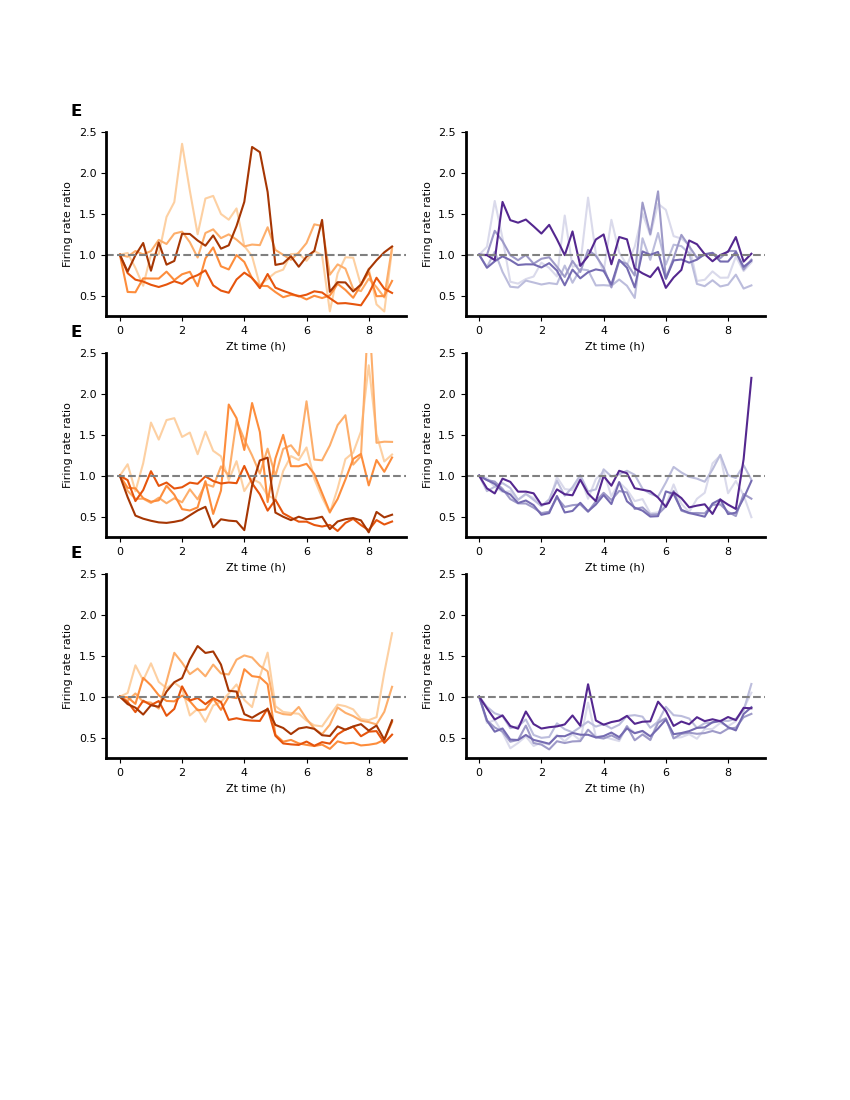

In [26]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw(grid=(4,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):

    for i1 in range(3):
        ax_1v5 = plt.subplot(gs[i1,i])
        df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp) & (frate_maze_vs_sd['sub']==i1)]
        sns.lineplot(
            data=df,
            x="bins",
            y="frate",
            hue="quantiles",
            palette=palette[i].hex_colors[1:],
            legend=None,
            ax=ax_1v5
        )   
        # ax_1v5.set_yscale('log')
        ax_1v5.axhline(1,ls='--',color='gray')
        ax_1v5.set_ylim(bottom=0.25,top=2.5)
        ax_1v5.set_ylabel('Firing rate ratio')
        ax_1v5.set_xlabel('Zt time (h)')
        if i==0:
            figure.panel_label(ax_1v5,'E')

# ax_caption = plt.subplot(gs[1, :])
# ax_caption.text(
#     0,
#     0,
#     "Figure: Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Gray curves denote firing rate changes if pentiles are randomly categorized (100 times).",
#     wrap=True,
# )
# ax_caption.axis("off")

figure.savefig(subjects.figpath_sd/'pentiles_pre_to_maze_POST_individual')